# Fallen Angel Risk Premia

In [1]:
suppressWarnings(require("TTR"))
suppressWarnings(require("arrow"))
suppressWarnings(require("ggplot2"))
suppressWarnings(require("tidyverse"))

Loading required package: TTR

Loading required package: arrow


Attaching package: ‘arrow’


The following object is masked from ‘package:utils’:

    timestamp


Loading required package: ggplot2

Loading required package: tidyverse

── Attaching core tidyverse packages ────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ──────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::duration() masks arrow::duration()
✖ dplyr::filter()       masks stats::filter()
✖ dplyr::lag()          masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## Get Data

In [4]:
get_data <- function(){

    file_path <- (file.path(
        dirname(dirname(getwd())),
        "data",
        "RawData",
        "RawPrices.parquet"))
    
    df_out <- (read_parquet(
        file_path))

    return(df_out)
}

df_prices <- get_data()

In [ ]:
df_prices %>% 
  select(date, security) %>% 
  group_by(security) %>% 
  filter(date == min(date) | date == max(date)) %>% 
  ungroup()

## Exploratory Data Analysis

Cumulative Basis Points

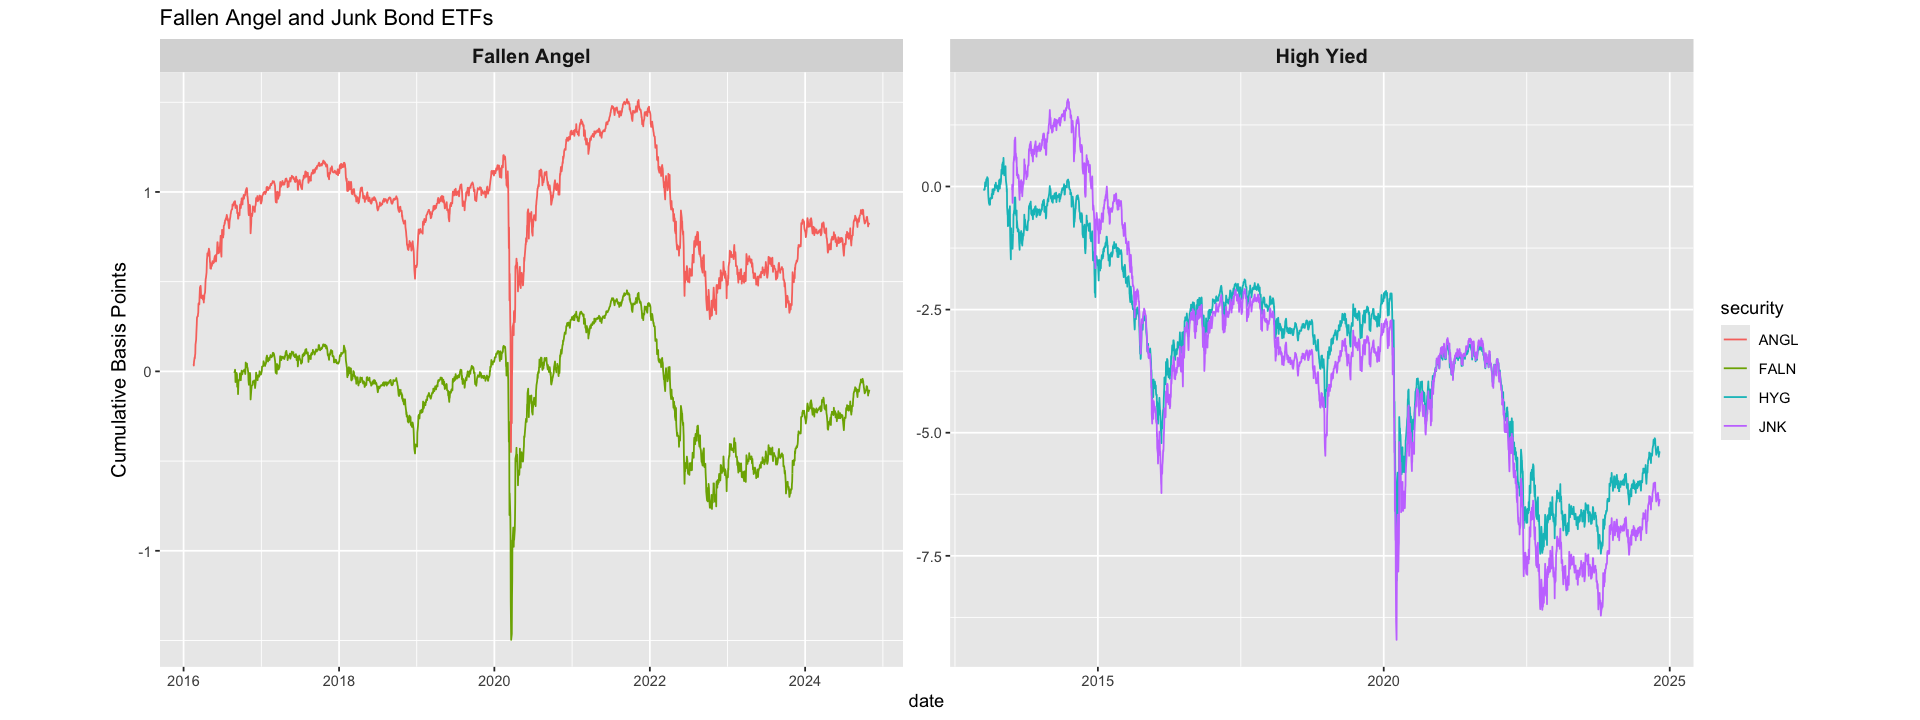

In [8]:
plot_rtns <- function(df_prices){

    options(repr.plot.width = 16, repr.plot.height = 6)
    
    df_prices %>% 
      select(security, date, PX_bps) %>% 
      drop_na() %>% 
      group_by(security) %>% 
      arrange(date) %>% 
      mutate(PX_bps = cumsum(PX_bps)) %>% 
      ungroup() %>% 
      mutate(sec_group = if_else(security %in% c("HYG", "JNK"), "High Yied", "Fallen Angel")) %>% 
      ggplot(aes(x = date, y = PX_bps, color = security)) +
      facet_wrap(~sec_group, scales = "free") +
      geom_line() +
      theme(aspect.ratio = 0.8) +
      labs(
          y     = "Cumulative Basis Points",
          title = "Fallen Angel and Junk Bond ETFs") +
      theme(
          strip.text   = element_text(size = 12, face = "bold"),
          axis.title.y = element_text(size = 12))
}
plot_rtns(df_prices)

Now comapre the duration

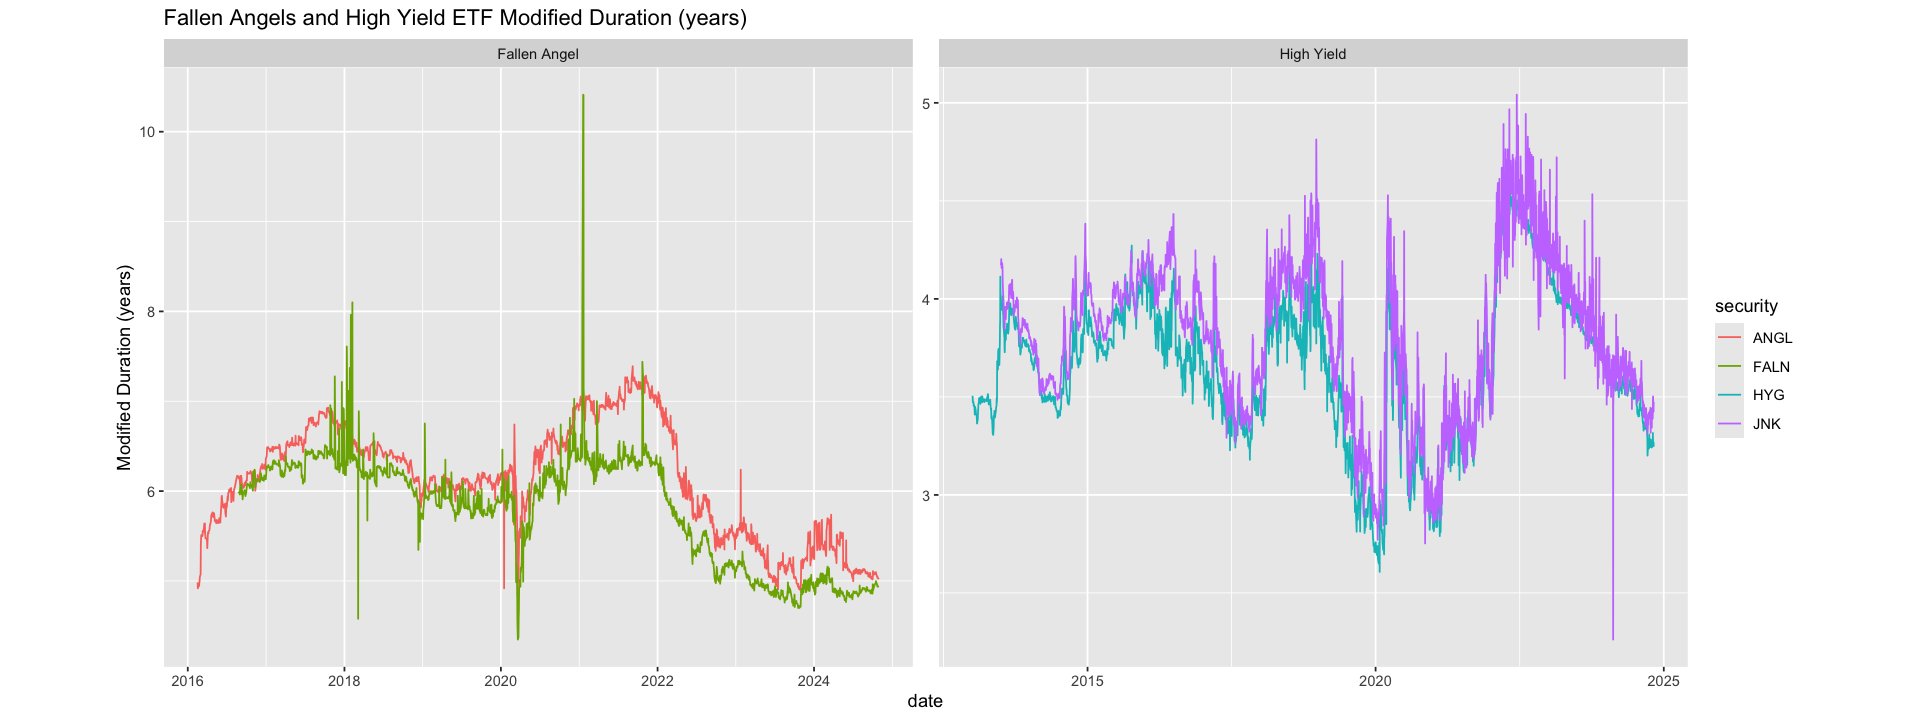

In [10]:
plot_duration <- function(df_prices){
  
  df_prices %>% 
    select(security, date, mod_dur) %>% 
    mutate(sec_group = if_else(security %in% c("HYG", "JNK"), "High Yield", "Fallen Angel")) %>% 
    ggplot(aes(x = date, y = mod_dur, color = security)) +
    facet_wrap(~sec_group, scale = "free") +
    geom_line() +
    theme(aspect.ratio = 0.8) +
    labs(
      y = "Modified Duration (years)",
      title = "Fallen Angels and High Yield ETF Modified Duration (years)")
}

plot_duration(df_prices)

In this case the data can be a bit too noisy with outliers smoothning it out via 5d EWMA should work. 

In [13]:
smooth_duration <- function(df_prices, window){
  
  df_out <- df_prices %>% 
    select(date, security, mod_dur) %>% 
    drop_na() %>% 
    group_by(security) %>% 
    arrange(date) %>% 
    mutate(mod_dur = EMA(mod_dur, n = window)) %>% 
    ungroup() %>% 
    drop_na()
  
  return(df_out)
}

df_smooth <- smooth_duration(df_prices, 5)

In [ ]:
plot_duration(df_smooth)

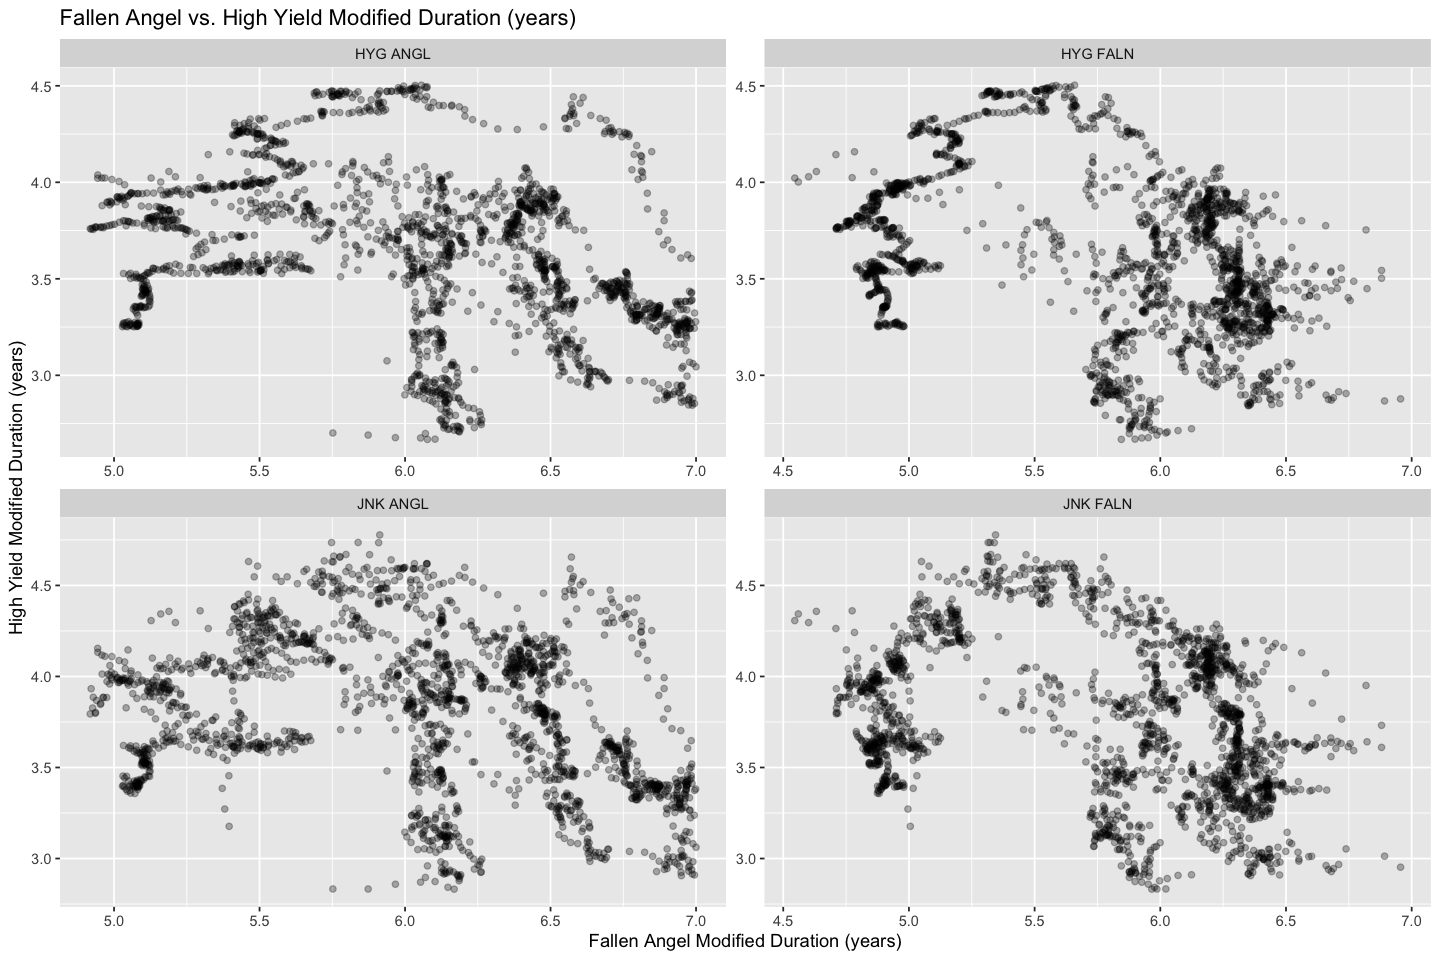

In [15]:
plot_duration_comparison <- function(df_smooth){

  options(repr.plot.width = 12, repr.plot.height = 8)
  df_hy <- df_smooth %>% 
    select(security, date, mod_dur) %>% 
    filter(security %in% c("HYG", "JNK")) %>% 
    rename(
      "hy_sec" = "security",
      "hy_dur" = "mod_dur")
  
  df_fa <- df_smooth %>% 
    select(security, date, mod_dur) %>% 
    filter(security %in% c("FALN", "ANGL")) %>% 
    rename(
      "fa_sec" = "security",
      "fa_dur" = "mod_dur") %>% 
    filter(fa_dur < 7)
  
  df_hy %>% 
    inner_join(df_fa, by = "date", relationship = "many-to-many") %>% 
    mutate(group_name = paste0(hy_sec, " ", fa_sec)) %>% 
    ggplot(aes(x = fa_dur, y = hy_dur)) +
    geom_point(alpha = 0.3) +
    facet_wrap(~group_name, scale = "free") +
    labs(
      x     = "Fallen Angel Modified Duration (years)",
      y     = "High Yield Modified Duration (years)",
      title = "Fallen Angel vs. High Yield Modified Duration (years)")
}

plot_duration_comparison(df_smooth)